# cfRNA Grade of membership model

*By Joe Marcus*

Here I explore cell-free RNA data generated by Koh et al. 2014. Paticuarly I downloaded RNA-seq count matricies from `recount2` for both the Koh et al. study as well as GTEx. Here I perform 3 experiments ...

* *Experiment 1* - Run an admixture model (for many values of K) on only the cell-free RNA dataset to reveal structure within the Koh et al. data **[done]**

* *Experiment 2* - Run an admixture model (for many values K) on the cell-free RNA dataset with the Koh et al. data merged with the GTEx project to see if we can observe a signature of particular tissues within the cell-free RNA. *[in progress]*

* *Experiment 3* - Run an admixture model (for many values of K) on the GTEx project and then project the cell-free RNA samples onto the structure existing amongst the tissues samples in the GTEx consortium. This is similar to matrix factorization approaches previously performed in a few different studies but within the admixture model framework (which is novel). *[in progress]*

# Configuration

In [6]:
suppressMessages(library(dplyr))
suppressMessages(library(CountClust))
suppressMessages(library(maptpx))
suppressMessages(library(mygene))

In [7]:
options(repr.plot.width=5, repr.plot.height=4)

# Data

## Paths

In [2]:
meta_df <- readRDS('../output/meta/koh_gtex_meta.rds')
koh_count_mat  <- readRDS('../output/counts/koh_count_dey_genes.rds')

# drop 32nd column because its all very small floating points close to 0 ... wierd outlier
koh_count_mat <- koh_count_mat[,-32]
koh_gom_path <- '../output/gom/koh_FitGoM.rda'

# Model

## Experiment 1

In [8]:
if(!file.exists(koh_gom_path)){
    FitGoM(t(koh_count_mat), K=c(2,3,4,5,6,7,8,9,10), tol=0.1, path_rda=koh_gom_path)   
} else {
    koh_gom_res <- load(file=koh_gom_path)
    koh_gom <- get(koh_gom_res)
}

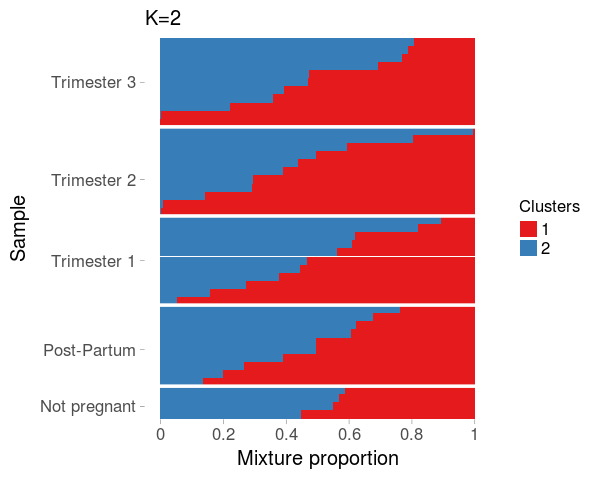

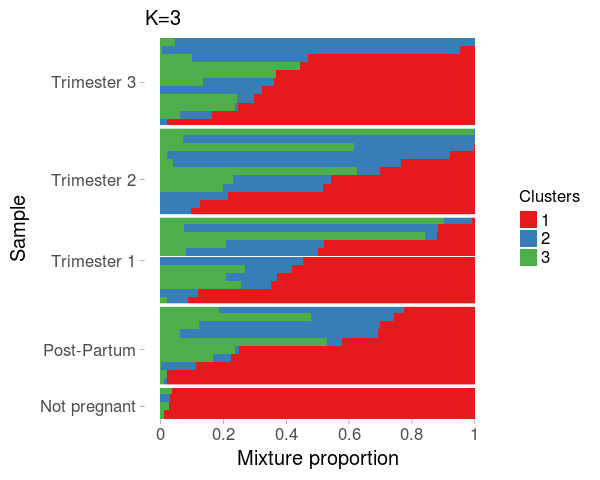

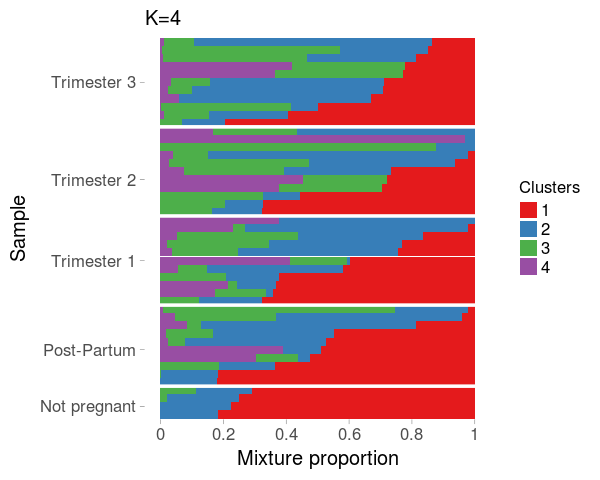

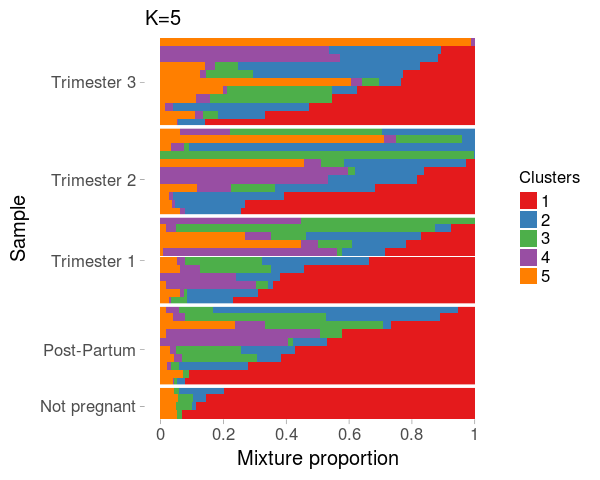

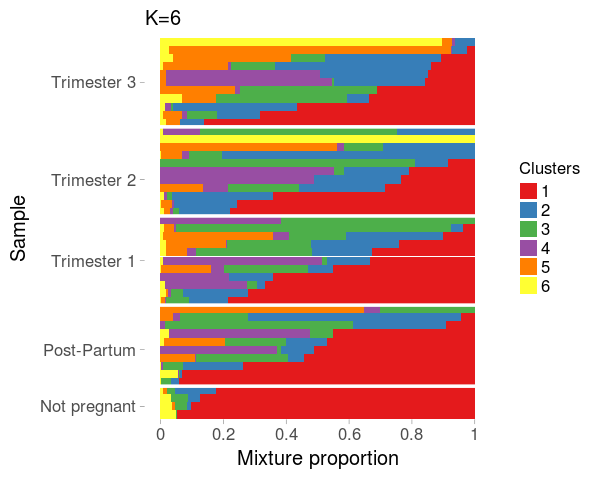

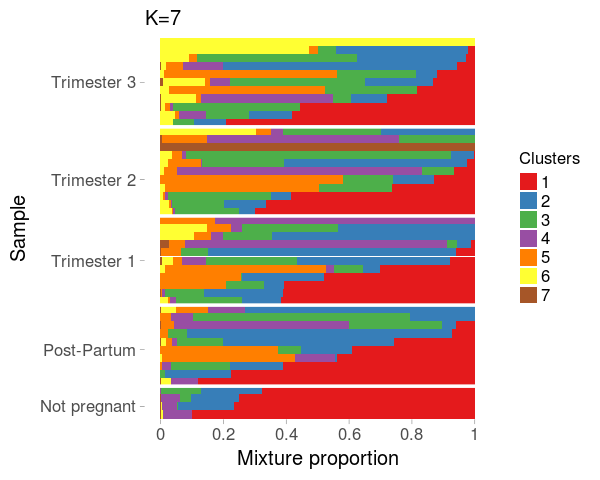

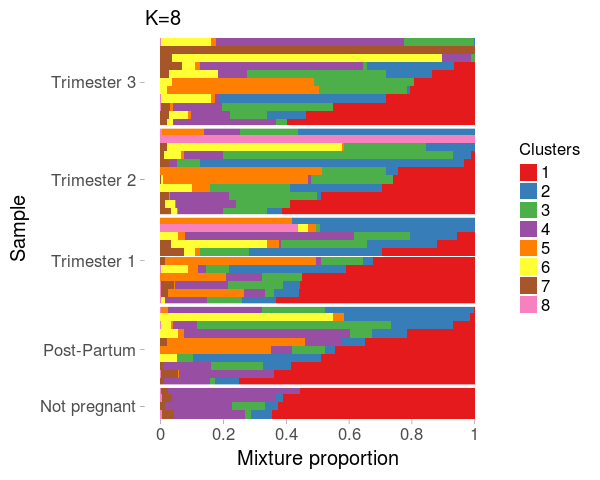

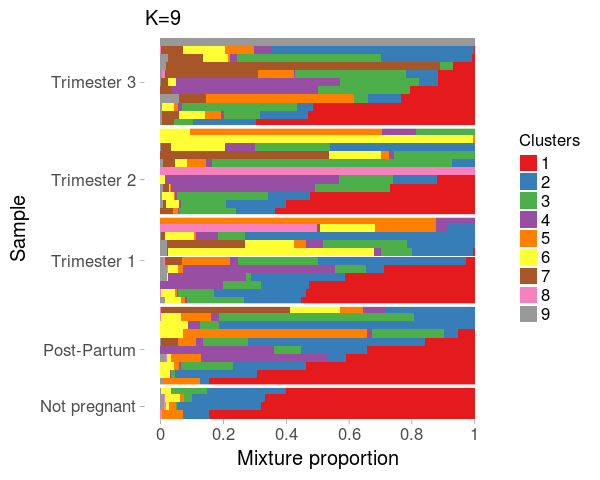

In [9]:
for(k in 2:9){

    # omega
    clust <- paste0('clust_', k)
    omega <- koh_gom[[clust]]$omega
    omega_df <- as.data.frame(omega)
    omega_df$run_id <- rownames(omega)
    omega_df <- omega_df %>% inner_join(meta_df, by=c('run_id'))
    
    # annotate
    annotation <- data.frame(sample_id=paste0(omega_df$run_id),
                             tissue_label=factor(omega_df$label))
    colnames(omega) <- 1:ncol(omega) 
    
    #############################################################
    
    # plot
    p <- StructureGGplot(omega = omega,
                         figure_title = paste0('K=', k),
                         annotation = annotation,
                         palette = RColorBrewer::brewer.pal(9, 'Set1'),
                         yaxis_label = 'Sample',
                         order_sample = TRUE,
                         axis_tick = list(axis_ticks_length = .1,
                                          axis_ticks_lwd_y = .1,
                                          axis_ticks_lwd_x = .1
                                          )) +
         theme(
               axis.title.y=element_text(size=12),
               axis.text.y =element_text(size=10),
               axis.title.x=element_text(size=12),
               axis.text.x =element_text(size=10),
               legend.title=element_text(size=10),
               legend.text=element_text(size=10),
               plot.title = element_text(size=12)
              ) +
         ylab('Mixture proportion') 
    
    print(p)
}

In [14]:
K <- 3
theta_mat <- koh_gom$clust_3$theta
top_features <- ExtractTopFeatures(theta_mat, top_features=20, 
                                   method='poisson', options='min')

gene_list <- do.call(rbind, 
                     lapply(1:dim(top_features$indices), 
                            function(x) rownames(koh_count_mat)[top_features$indices[x,]]))

for(k in 1:K){
    gene_df <- queryMany(gene_list[k,],  scopes='ensembl.gene', 
                         fields=c('name', 'summary', 'symbol'), 
                         species='human')        
    
    print(knitr::kable(gene_df[,c('symbol', 'name')]))
    write(gene_df[,'symbol'], file =paste0('K.', k, '.txt'))
}

Warning message in 1:dim(top_features$indices):
“numerical expression has 2 elements: only the first used”

Finished


|symbol   |name                                                                                              |
|:--------|:-------------------------------------------------------------------------------------------------|
|TRAK2    |trafficking kinesin protein 2                                                                     |
|ETS1     |ETS proto-oncogene 1, transcription factor                                                        |
|LCP1     |lymphocyte cytosolic protein 1                                                                    |
|CBX5     |chromobox 5                                                                                       |
|CCND2    |cyclin D2                                                                                         |
|NCL      |nucleolin                                                                                         |
|NET1     |neuroepithelial cell transforming 1                                                       

## Experiment 2

## Experiment 3